### James Butcher - 5-27-25

Copied from Grok's sample starter code when I described my goals for this project.

## Basic imports

In [1]:
import os
import random
from typing import TypedDict, List

Set recursion limit higher than the default 25 so the model can loop more than 25 times

In [2]:
import sys
sys.setrecursionlimit(200)

## LLM

In [3]:
from langchain_ollama import ChatOllama

model_path = os.path.expanduser(
    "~/.cache/lm-studio/models/lmstudio-community/"
    "Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

""" API Docs: 
https://python.langchain.com/api_reference/ollama/chat_models/langchain_ollama.chat_models.ChatOllama.html
"""
llm = ChatOllama(
    model="llama3.2",
    model_path=model_path,
    chat_format="chatml", # Works with most models
    temperature=1.0,  # Controlds the randomness/creativity [0.0 - 2.0]
    num_predict=128,  # Max number of tokens
    #n_ctx=4096, # Context length - default: 2048 (others are 512, 1024, 4096)
    #n_threads=4, # Number of threads to use for inference (default is 4)
    #num_predict=128  # Maximum number of tokens to predict when generating text. (Default: 128, -1 = infinite generation, -2 = fill context)
)

In [4]:
MAX_TOKENS_PER_RESPONSE = 60

## Types and Fields imports

In [5]:
from typing import Annotated, Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

## LangGraph Imports

In [6]:
from langgraph.graph import StateGraph, START, END  # For building the graph
from langgraph.graph.message import add_messages    # For defining states

## Define Special Models

For special LLM nodes that do tasks like classification, tool calling, etc.

In [7]:
# class MessageClassifier(BaseModel):
#     message_type: Literal["emotional", "logical"] = Field(
#         ..., 
#         description="Classify whether the message requires an" \
#         "emotional or a logical response."
#     )

## Define States

Define the structure of the "States" to be used by the graph
The below definition forces states to be of this form:
```
{ 
    "messages": [ <messages list> ]
    "message_type": str ("logical" or "therapist")
}
```

In [8]:
class State(TypedDict):
    workspace: str
    goals: str
    history: List[str]
    satisfaction: float

### Logging outputs

In [9]:
from datetime import datetime

def create_chat_log():
    chat_filename = "output_" + datetime.now().strftime("%Y-%m-%d_(%H%M)") + ".txt"
    chat_filepath = "ChatLogs/" + chat_filename
    with open(chat_filepath, "w") as out:
        out.write(str(datetime.now()) + "\n" + '-'*50 + "\n\n")
    return chat_filepath

log_path = create_chat_log()

In [10]:
def write_to_log(path: str, message: str):
    if len(message) > 2 and message[-1] != "\n":
        message += "\n"
    print(message)
    with open(path, "a") as out:
        out.write(message + "\n")

## Invoking the LLM

In [11]:
def get_formatted_prompt(state: State, prompt: str) -> str:
    prompt += f"\nKeep your response to {MAX_TOKENS_PER_RESPONSE} words or less.\n"
    num_past_messages = len(state['history'])
    if num_past_messages > 1:
        prompt += "Here are your most recent thoughts and changes:"
        for i in range(1, min(num_past_messages, 10)):
            prompt += "\n" + state['history'][-i]
    return prompt

In [12]:
def call_llm(prompt: str) -> str:
    return llm.invoke(prompt).content

### Define "Feelings" and its effect on "Satisfaction"

In [25]:
feelings_to_satisfaction_dict = {
    "excited": 0.2, 
    "confident": 0.1,
    "hopeful": 0.05,
    "normal": 0.0,
    "unsure": -0.05,
    "uninspired": -0.1,
    "frustrated": -0.2
}
feelings = ", ".join(['"' + f + '"' for f in feelings_to_satisfaction_dict.keys()])
print(feelings)

"excited", "confident", "hopeful", "normal", "unsure", "uninspired", "frustrated"


## Define Nodes (Actions)

Define a node by creating a function that takes a state and returns a modified state.

In [26]:
def make_change(state: State) -> State:
    prompt = get_formatted_prompt(state, f"""
        Based on the work: '{state['workspace']}', make a creative change.
        Return the modified work only.
    """)
        
    change = call_llm(prompt)
    state['workspace'] = f"\n{change}"
    state['history'].append(f"[Modified work]: {change}")
    write_to_log(log_path, f"\n[Modified work]: {change}")
    return state

def think(state: State) -> State:
    prompt = get_formatted_prompt(state, f"""
    Given your work: '{state['workspace']}' and goals: '{state['goals']}', what’s the next step?
    """)
        
    idea = call_llm(prompt)
    state['history'].append(f"[Thought]: {idea}")
    write_to_log(log_path, f"\n[Thought]: {idea}")
    return state

def criticize(state: State) -> State:
    prompt = get_formatted_prompt(state, f"""
    Evaluate the latest change in: '{state['workspace']}' for goals: '{state['goals']}'.
    """)
    print("\nPROMPT----------------:" + prompt + "\n--------------------\n")
        
    critique = call_llm(prompt)
    state['history'].append(f"[Critique]: {critique}")
    write_to_log(log_path, f"\n[Critique]: {critique}")
    return state

def reflect(state: State) -> State:
    prompt = get_formatted_prompt(state, f"""
    Reflect on progress in: '{state['workspace']}' toward goals: '{state['goals']}'.
    How are you feeling about your progress and direction?
    Finish with one of these words to summarize your reflection feelings: ({feelings}).
    """)
    print("\nPROMPT----------------:" + prompt + "\n-------------------\n")
        
    reflection = call_llm(prompt)
    state['history'].append(f"[Reflection]: {reflection}")
    write_to_log(log_path, f"\n[Reflection]: {reflection}")

    satisfaction_change = 0.1
    for feeling, satisfaction in feelings_to_satisfaction_dict.items():
        if feeling.lower() in reflection.split()[-1].lower():
            satisfaction_change = satisfaction
        
    state['satisfaction'] = state['satisfaction'] + satisfaction_change


    msg = ""
    if satisfaction_change > 0.0:
        msg = "Satisfaction increased by"
    elif satisfaction_change < 0.0:
        msg = "Satisfaction decreased by"
    else:
        msg = "Satisfaction unchanged. "
        
    
    write_to_log(log_path, f"{msg} {satisfaction_change}: [ {state['satisfaction']} ]")


    if satisfaction < -0.5:
        prompt = get_formatted_prompt(state, f"""
        You are frustrated with your work on '{state['workspace']}' toward goals: '{state['goals']}',
        and now you don't want to pursue that goal anymore.
        Respond with a new worthwhile goal that aligns better with your past thoughts and preferences.
        Respond with the new goal only.
        """)
        print("\nPROMPT-------------:" + prompt + "\n--------------\n")
            
        new_goal = call_llm(prompt)
        state['goals'] = (f"[New Goal]: {new_goal}")
        write_to_log(log_path, f"\n[New Goal]: {new_goal}")

    return state


def decide(state: State) -> State:
    if state['satisfaction'] >= 0.9 or random.random() < 0.1:
        print("\nDecided to stop.")
        return {"next": END}
    print("\nDecided to make a change.")
    return {"next": "make_change"}

## Build the Graph

In [27]:
workflow = StateGraph(State)

#### Add all the nodes defined above

In [28]:
workflow.add_node("make_change", make_change)
workflow.add_node("think", think)
workflow.add_node("criticize", criticize)
workflow.add_node("reflect", reflect)
workflow.add_node("decide", decide)

#### Connect all the nodes
- All graphs require a start and end node.

In [29]:
workflow.add_edge(START, "make_change")
workflow.add_edge("make_change", "think")
workflow.add_edge("think", "criticize")
workflow.add_edge("criticize", "reflect")
workflow.add_edge("reflect", "decide")
workflow.add_conditional_edges(
    "decide",
    lambda state: state.get("next"), {
        "make_change": "make_change",
        END: END
    }
)

#### Compile the graph

In [30]:
graph = workflow.compile()

#### Display the graph

Only works in Jupyter Notebook

In [31]:
from IPython.display import Image, display

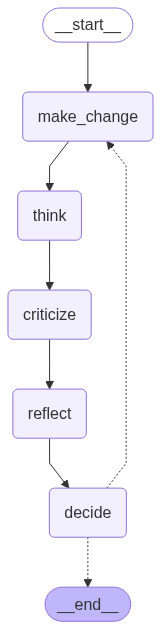

In [32]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This reqires some additional dependencies and is optional
    pass

# Usage

#### Define functions for interacting with graph

In [33]:
def get_initial_state():
    return { 
        "workspace": "The robot powered on in a quiet lab.",
        "goals": "Write a suspenseful robot love story",
        #"goals": "Write a suspenseful robot love story",
        "history": [],
        "satisfaction": 0.0
    }

In [34]:
# def run_graph(state: State, chat_log_path: str):

#     user_input = input("Message: ")
    
#     write_to_log(chat_log_path, f"User: {user_input}")

#     # Append user input to the messages stored in state
#     state["messages"] = state.get("messages", []) + [
#         {"role": "user", "content": user_input}
#     ]

#     # Invoke the LLM on the state containing the new user input
#     state = graph.invoke(state)

#     # Display the LLM's response and write to log
#     if state.get("messages") and len(state["messages"]) > 0:
#         last_message = state["messages"][-1]
#         print(f"Assistant: {last_message.content}")
#         write_to_log(chat_log_path, "Assistant: " + last_message.content + "\n\n" + '-'*50)


#### Run the graph

In [35]:
#log = create_chat_log()

In [36]:
state = get_initial_state()

In [37]:
result = graph.invoke(state)
print("Final Story:", result["workspace"])
print("Final Goals:", result["goals"])
print("History:", result["history"])


[Modified work]: "The laboratory erupted in a chaotic symphony as the robot powered on, its lights flashing like fireflies on a summer night."


[Thought]: Next, I'd develop Zeta, the protagonist robot, by adding depth with its unique characteristics, motivations, and emotions. Perhaps it's a reactivated prototype with fragmented memories of a past love, driving its search for human connection. This would set the stage for an exploration of artificial emotions and the blurring of lines between creator and creation.


PROMPT----------------:
    Evaluate the latest change in: '
"The laboratory erupted in a chaotic symphony as the robot powered on, its lights flashing like fireflies on a summer night."' for goals: 'Write a suspenseful robot love story'.
    
Keep your response to 60 words or less.
Here are your most recent thoughts and changes:
[Thought]: Next, I'd develop Zeta, the protagonist robot, by adding depth with its unique characteristics, motivations, and emotions. Perhaps it

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
# def run_graph():

#     # Set initial state
#     state = { 
#         "messages": [],
#         "message_type": None
#     }

#     # Create an output log file
#     from datetime import datetime
#     output_filename = "output_" + datetime.now().strftime("%Y-%m-%d_%H:%M") + ".txt"
#     with open(output_filename, "w") as out:
#             out.write(str(datetime.now()) + "\n" + '-'*50)

#     while True:

#         # Get user input
#         user_input = input("Message: ")
#         if user_input.lower() in ["q", "quit", "bye", "exit"]:
#             print("Bye")
#             break

#         # Write the user input to the log
#         with open(output_filename, "a") as out:
#             out.write(f"User: {user_input}\n\n")

#         # Append user input to the messages stored in stateA
#         state["messages"] = state.get("messages", []) + [
#             {"role": "user", "content": user_input}
#         ]

#         # Invoke the LLM on the state containing the new user input
#         state = graph.invoke(state)

#         # Display the LLM's response and write to log
#         if state.get("messages") and len(state["messages"]) > 0:
#             last_message = state["messages"][-1]
#             print(f"Assistant: {last_message.content}")
#             with open(output_filename, "a") as out:
#                 out.write(f"Assistant: {last_message.content}\n\n" + '-'*50 + "\n")

In [ ]:
run_graph()